# Imports

In [378]:
import numpy as np
import pickle
import os
import re
import pandas as pd
from tqdm import tqdm
import glob
import networkx as nx

import sys
sys.path.append("../../scripts") # TODO: make this part of pythonpath?

import matplotlib.pyplot as plt

from scripts.run_bubblewrap import BubblewrapRun

In [379]:
rng = np.random.default_rng()

In [380]:
%matplotlib inline
all_inline = True

# Individual analysis

## Individial file discovery/loading

In [402]:
# list recently created files

files = glob.glob("*pickle")
files.sort()
files[-5:]

['bubblewrap_run_2023-06-15-13-17-48.pickle',
 'bubblewrap_run_2023-06-15-13-32-52.pickle',
 'bubblewrap_run_2023-06-15-14-10-44.pickle',
 'bubblewrap_run_2023-06-15-14-18-54.pickle',
 'bubblewrap_run_2023-06-15-14-51-49.pickle']

In [403]:
# select file to use for br

file = 'bubblewrap_run_2023-06-13-13-09-38.pickle'
file = files[-1]
file

'bubblewrap_run_2023-06-15-14-51-49.pickle'

In [404]:
# load br

with open(file, "rb") as fhan:
    br = pickle.load(fhan)

for key, value in br.bw_parameters.items():
    print(f"{key}: {value}")
print(f"input file: {br.file}")
print(f"savefile: {br.outfile}")
print(f"# of used nodes: {br.A.shape[0]- len(br.dead_nodes)}")
print(f"# of steps: {br.entropy_list.shape[0]}")

num: 2500
lam: 0.001
nu: 0.001
eps: 0.001
step: 0.08
M: 100
B_thresh: -10
batch: False
batch_size: 1
go_fast: False
lookahead_steps: [1, 2, 5, 10]
seed: 42
save_A: False
balance: 1
beh_reg_constant_term: True
behavior_shift: 1
input file: ./generated/datasets/mouse_stringer_smoothed_4d.npz
savefile: generated/bubblewrap_runs/bubblewrap_run_2023-06-15-14-51-49.pickle
# of used nodes: 1000
# of steps: 1000


In [366]:
# show error over time

%matplotlib qt
fig, ax = plt.subplots()

ax.plot((br.beh_error_list), '-')
ax.set_ylabel("squared error")
ax.set_xlabel("time");

In [367]:
# show regret over time

%matplotlib qt
fig, ax = plt.subplots()
r = np.squeeze(br.beh_regr_list)
x = np.arange(r.shape[0])+1
ax.plot(x,r[:,[0,1,2],[0,1,2]], '-')
ax.set_ylabel("regret")
ax.set_xlabel("time");

In [368]:
# retreive behavior data from the same run

with np.load("../../"+br.file) as s:
        data = s['y'][0]
        obs = s['x']


In [369]:
x = np.arange(obs.shape[0])
plt.plot(x,obs)

x = np.arange(br.beh_list.shape[0]) + 801
plt.plot(x,br.beh_list)

plt.legend(['true z', 'true -x', 'true -y', 'pred. z', 'pred. -x', 'pred -y',])


In [370]:
br.entropy_list.shape

(21054, 4)

In [371]:
obs.shape

(21055, 14)

In [372]:
br.beh_list

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.5201665e-02,  3.7798782e+01,  2.4077217e+01, ...,
        -3.8198807e+01, -1.3205194e+02,  1.0318713e+01],
       [ 4.2050742e-02,  5.0354664e+01,  3.2062622e+01, ...,
        -9.6248299e+01, -1.4285490e+02,  1.9336081e+01],
       ...,
       [ 4.3880568e+00,  8.3944458e+01,  5.2374729e+01, ...,
         1.3839099e+01,  6.1005435e+00,  1.1850549e+01],
       [ 4.4025927e+00,  8.3958359e+01,  5.2375938e+01, ...,
         1.4115180e+01,  6.3867388e+00,  1.1784117e+01],
       [ 4.4149776e+00,  8.3973213e+01,  5.2376980e+01, ...,
         1.4298821e+01,  6.6954141e+00,  1.1712241e+01]], dtype=float32)

In [500]:
g_files = glob.glob("*pickle")
g_files.sort()

files = [
    # 'bubblewrap_run_2023-06-15-15-29-33.pickle',
] + g_files[-1:]

brs = []
for file in files:
    with open(file, "rb") as fhan:
        br = pickle.load(fhan)
    brs.append(br)

In [501]:
%matplotlib qt
def one_sided_ewma(data, com=100):
    return pd.DataFrame(data=dict(data=data)).ewm(com).mean()["data"]

def compare_metrics(brs, recovered_plots = False):
    ps = [br.bw_parameters for br in brs]
    keys = set([leaf for tree in ps for leaf in tree.keys()])
    keep_keys = []
    for key in keys:
        values = [d.get(key) for d in ps]
        if not all([values[0] == v for v in values]):
            keep_keys.append(key)
    to_print = []
    for key in keep_keys:
        to_print.append(f"{key}: {[p.get(key) for p in ps]}")
    
    for p in to_print:
        print(p)
    
    fig, ax = plt.subplots(figsize=(12,5), nrows=3, ncols=1, sharex=True, layout='tight')
    to_write = [[],[],[]]

    smooting_scale = 100
    n = 0
    for idx, br in enumerate(brs):
        n = max(n,br.entropy_list.shape[0])
        
        xlim = np.array([-0.01 * n,n])
        xlim[1] *= 1.07
        
        # predictions = br.pred_list[br.bw_parameters["M"]+1:,0]
        predictions = br.pred_list[:,0]
        smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

        ax[0].plot(predictions, alpha=0.25, color='blue')
        c = 'black' if idx ==0 else 'blue'
        ax[0].plot(smoothed_predictions, color=c, label = br.outfile.split("/")[-1].split(".")[0].split("_")[-1])
        # ax[0].tick_params(axis='y',labelcolor='blue')
        # ax[0].text(1800,-12-2*idx,f"~{smoothed_predictions[smoothed_predictions.shape[0]//2:].mean():.2f}", color=c)
        ax[0].set_ylabel('prediction')
        to_write[0].append((idx, f"{predictions[n//2:].mean():.3f}", dict(color = c)))



 
        entropy = br.entropy_list[:,0]
        smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
        ax[1].plot(entropy, color='green', alpha=0.25)
        c = 'black' if idx == 0 else 'green'
        ax[1].plot(smoothed_entropy, color=c)
        max_entropy = np.log2(br.bw_parameters["num"])
        ax[1].plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
        # ax[1].tick_params(axis='y',labelcolor='green')
        # ax[1].text(1500,-12-2*idx,f"~{smoothed_entropy[smoothed_entropy.shape[0]//2:].mean():.2f}", color=c)
        ax[1].set_ylabel('entropy')
        to_write[1].append((idx, f"{entropy[n//2:].mean():.3f}", dict(color = c)))
        
        beh_error = np.squeeze(br.beh_error_list)
        c = 'black' if idx == 0 else 'orange'
        ax[2].plot(beh_error, color=c)
        ax[2].set_ylabel('behavior')
        # ax[2].tick_params(axis='y',labelcolor='green')
        to_write[2].append((idx, f"{beh_error[n//2:].mean():.3f}", dict(color = c)))
        
#         living = np.squeeze(br.n_living_list)
#         c = 'black' if idx == 0 else 'orange'
#         ax[2].plot(living, color=c)
#         ax[2].set_ylabel('number living')
#         # ax[2].tick_params(axis='y',labelcolor='green')
#         to_write[2].append((idx, f"{living[n//2:].mean():.3f}", dict(color = c)))
    
    for i,l in enumerate(to_write):
        ylim = ax[i].get_ylim()
        yrange = ylim[1] - ylim[0]
        for idx, text, kw in l:
            ax[i].text(n*1.01, ylim[1] - (idx+1) * yrange/7, text, clip_on=True, **kw)
    
    xticks = list(ax[2].get_xticks())
    xticks.append(n//2)
    ax[2].set_xticks(xticks)
    ax[0].set_xlim(xlim)
    ax[0].set_title(" ".join(to_print))
    # ax[0].legend(loc="lower right")
    
    # ax[2].set_ylim([0,1000])
    
    


compare_metrics(brs)

In [502]:
files

['bubblewrap_run_2023-06-15-16-17-02.pickle']

In [376]:
brs[0].pred_list

array([[-36.841362, -36.841362, -36.841362, -36.841362],
       [-36.841362, -36.841362, -36.841362, -36.841362],
       [-36.841362, -36.841362, -36.841362, -36.841362],
       ...,
       [-36.841362, -36.841362,        nan,        nan],
       [-36.841362, -36.841362,        nan,        nan],
       [-36.841362, -36.841362,        nan,        nan]])

In [656]:
df = []
# df.append(dict(
#     data_in="f[:,0]",
#     data_predicted="f[:,0]",
#     updated_alpha=False,
#     file="bubblewrap_run_2023-06-13-14-52-42.pickle"
# ))

# df.append(dict(
#     data_in="psvd(n)[:,:6]",
#     data_predicted="f[:,0]",
#     updated_alpha=False,
#     file="bubblewrap_run_2023-06-13-14-54-38.pickle"
# ))


# df.append(dict(
#     data_in="[psvd(n)[:,:6], f[:,0]]",
#     data_predicted="f[:,0]",
#     updated_alpha=False,
#     file="bubblewrap_run_2023-06-13-14-57-42.pickle"
# ))



df.append(dict(
    data_in="f[:20k,0]",
    data_predicted="f[:20k+n,0]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-13-15-53-29.pickle"
))

df.append(dict(
    data_in="psvd(n)[:20k,:6]",
    data_predicted="f[:20k+n,0]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-13-15-10-19.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,0]]",
    data_predicted="f[:20k+n,0]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-13-15-12-21.pickle"
))


df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,0]]",
    data_predicted="psvd(n)[:20k+n,0]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-13-15-25-50.pickle"
))

df.append(dict(
    data_in="psvd(n)[:20k,:6]",
    data_predicted="psvd(n)[:20k+n,0]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-13-15-27-02.pickle"
))

df.append(dict(
    data_in="f[:20k,0]",
    data_predicted="psvd(n)[:20k+n,0]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-13-16-02-33.pickle"
))

df.append(dict(
    data_in="psvd(n)[:20k,:6]",
    data_predicted="f[:20k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-09-21-15.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,:]]",
    data_predicted="f[:20k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-09-25-02.pickle"
))

df.append(dict(
    data_in="f[:20k,:]",
    data_predicted="f[:20k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-09-26-36.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,1:]]",
    data_predicted="f[:20k+n,0]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-09-31-27.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,:2]]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-09-33-36.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,:2]]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=5,
    file="bubblewrap_run_2023-06-14-09-52-32.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,:2]]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=10,
    file="bubblewrap_run_2023-06-14-09-55-19.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,:2]]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=20,
    file="bubblewrap_run_2023-06-14-09-46-35.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-10-04-05.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=5,
    file="bubblewrap_run_2023-06-14-09-59-56.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=10,
    file="bubblewrap_run_2023-06-14-10-02-10.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=50,
    file="bubblewrap_run_2023-06-14-11-18-18.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=99,
    file="bubblewrap_run_2023-06-14-10-40-34.pickle"
))


df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=100,
    file="bubblewrap_run_2023-06-14-10-08-48.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=101,
    file="bubblewrap_run_2023-06-14-10-38-50.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=150,
    file="bubblewrap_run_2023-06-14-10-37-02.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=200,
    file="bubblewrap_run_2023-06-14-10-35-03.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=500,
    file="bubblewrap_run_2023-06-14-10-30-11.pickle"
))

df.append(dict(
    data_in="f[:20k,:2]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=1000,
    file="bubblewrap_run_2023-06-14-10-31-59.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,:2]]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=50,
    file="bubblewrap_run_2023-06-14-11-14-57.pickle"
))


df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,:2]]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=100,
    file="bubblewrap_run_2023-06-14-10-50-08.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,:2]]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=200,
    file="bubblewrap_run_2023-06-14-11-02-29.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6], f[:20k,:2]]",
    data_predicted="f[:20k+n,2]",
    n_steps_ahead=500,
    file="bubblewrap_run_2023-06-14-11-04-56.pickle"
))


df.append(dict(
    data_in="[psvd(n)[:20k,:6], f]",
    data_predicted="d(f[:20k+n,:])",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-11-31-41.pickle"
))

df.append(dict(
    data_in="psvd(n)[:20k,:6]",
    data_predicted="d(f[:20k+n,:])",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-11-34-31.pickle"
))

df.append(dict(
    data_in="f",
    data_predicted="d(f[:20k+n,:])",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-11-36-36.pickle"
))


df.append(dict(
    data_in="[psvd(n)[:70587,:6],f[:70587,:2]]",
    data_predicted="f[:70587+n,2]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-12-34-23.pickle"
))


df.append(dict(
    data_in="[psvd(n)[:20k,:6],f[:20k,:]]",
    data_predicted="psvd(n)[:20k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-13-59-08.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6],f[:20k,:]]",
    data_predicted="psvd(n)[:20k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-14-31-53.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6],f[:20k,0]]",
    data_predicted="psvd(n)[:20k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-14-33-08.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:20k,:6],f[:20k,1]]",
    data_predicted="psvd(n)[:20k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-14-34-56.pickle"
))

df.append(dict(
    data_in="psvd(n)[:20k,:6]",
    data_predicted="psvd(n)[:20k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-14-36-08.pickle"
))

df.append(dict(
    data_in="f[:20k,0]",
    data_predicted="psvd(n)[:20k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-14-37-19.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:70k,:6], f[:70k,:]]",
    data_predicted="[psvd(n)[:70k+n,:6],f[:70k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-15-31-11.pickle"
))

df.append(dict(
    data_in="psvd(n)[:70k,:6]",
    data_predicted="[psvd(n)[:70k+n,:6],f[:70k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-15-48-02.pickle"
))

df.append(dict(
    data_in="f[:70k,:]",
    data_predicted="[psvd(n)[:70k+n,:6],f[:70k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-15-53-30.pickle"
))

df.append(dict(
    data_in="[psvd(n)[:70k,:6], f[:70k,:]]",
    data_predicted="[psvd(n)[:70k+n,:6],f[:70k+n,:]",
    n_steps_ahead=1,
    file="bubblewrap_run_2023-06-14-17-18-03.pickle"
))

In [681]:
df = []

df.append(dict(
    data_in="[n,b]",
    data_predicted="[n,b]",
    n_steps_ahead=0,
    file='bubblewrap_run_2023-06-16-11-18-29.pickle'
))

df.append(dict(
    data_in="n",
    data_predicted="[n,b]",
    n_steps_ahead=0,
    file='bubblewrap_run_2023-06-16-11-21-06.pickle'
))

df.append(dict(
    data_in="b",
    data_predicted="[n,b]",
    n_steps_ahead=0,
    file='bubblewrap_run_2023-06-16-11-23-42.pickle'
))

df.append(dict(
    data_in="[n,b]",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-16-11-26-15.pickle'
))

df.append(dict(
    data_in="n",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-16-11-28-42.pickle'
))

df.append(dict(
    data_in="b",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-16-11-31-16.pickle'
))


df.append(dict(
    data_in="[n,b]",
    data_predicted="[n,b]",
    n_steps_ahead=2,
    file='bubblewrap_run_2023-06-16-11-33-47.pickle'
))

df.append(dict(
    data_in="n",
    data_predicted="[n,b]",
    n_steps_ahead=2,
    file='bubblewrap_run_2023-06-16-11-36-14.pickle'
))

df.append(dict(
    data_in="b",
    data_predicted="[n,b]",
    n_steps_ahead=2,
    file='bubblewrap_run_2023-06-16-11-38-48.pickle'
))

df.append(dict(
    data_in="[n,b]",
    data_predicted="[n,b]",
    n_steps_ahead=5,
    file='bubblewrap_run_2023-06-16-11-41-20.pickle'
))

df.append(dict(
    data_in="n",
    data_predicted="[n,b]",
    n_steps_ahead=5,
    file='bubblewrap_run_2023-06-16-11-43-51.pickle'
))

df.append(dict(
    data_in="b",
    data_predicted="[n,b]",
    n_steps_ahead=5,
    file='bubblewrap_run_2023-06-16-11-46-21.pickle'
))


df.append(dict(
    data_in="[n,b]",
    data_predicted="[n,b]",
    n_steps_ahead=10,
    file='bubblewrap_run_2023-06-16-11-48-49.pickle'
))

df.append(dict(
    data_in="n",
    data_predicted="[n,b]",
    n_steps_ahead=10,
    file='bubblewrap_run_2023-06-16-11-51-20.pickle'
))

df.append(dict(
    data_in="b",
    data_predicted="[n,b]",
    n_steps_ahead=10,
    file='bubblewrap_run_2023-06-16-11-53-49.pickle'
))

df.append(dict(
    data_in="[n,b]",
    data_predicted="[n,b]",
    n_steps_ahead=100,
    file='bubblewrap_run_2023-06-16-11-56-18.pickle'
))

df.append(dict(
    data_in="n",
    data_predicted="[n,b]",
    n_steps_ahead=100,
    file='bubblewrap_run_2023-06-16-11-58-47.pickle'
))

df.append(dict(
    data_in="b",
    data_predicted="[n,b]",
    n_steps_ahead=100,
    file='bubblewrap_run_2023-06-16-12-01-19.pickle'
))

In [671]:
df = []

df.append(dict(
    data_in="[n, b]",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-15-16-54-37.pickle'
))

df.append(dict(
    data_in="n",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-15-16-55-57.pickle'
))

df.append(dict(
    data_in="b",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-15-16-58-02.pickle'
))

df.append(dict(
    data_in="z(b,n)",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-16-10-44-49.pickle'
))

df.append(dict(
    data_in="z(b,n)",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-16-10-56-11.pickle'
))

df.append(dict(
    data_in="z(n)",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-16-10-57-21.pickle'
))

df.append(dict(
    data_in="z(b)",
    data_predicted="[n,b]",
    n_steps_ahead=1,
    file='bubblewrap_run_2023-06-16-10-58-24.pickle'
))









In [682]:
df = pd.DataFrame(df)

for idx in df.index:
    with open(df.loc[idx,"file"], "rb") as fhan:
        br = pickle.load(fhan)
    df.loc[idx,"mse"] = br.beh_error_list[len(br.beh_error_list)//2:].mean() 
    df.loc[idx, 'br'] = br
    df.loc[idx, 'data_predicted'] = df.loc[idx, 'data_predicted'].replace("+n", f"+{df.loc[idx, 'n_steps_ahead']}")
    # df.loc[idx, 'pred_shape'] = ([int(x) for x in br.beh_list.shape],)

In [683]:
df[["data_in", "data_predicted", "n_steps_ahead", "mse"]][:]

,data_in,data_predicted,n_steps_ahead,mse
0,"[n,b]","[n,b]",0,3.064386
1,n,"[n,b]",0,3.459752
2,b,"[n,b]",0,1.461911
3,"[n,b]","[n,b]",1,3.089961
4,n,"[n,b]",1,3.462476
5,b,"[n,b]",1,1.440156
6,"[n,b]","[n,b]",2,3.093496
7,n,"[n,b]",2,3.464172
8,b,"[n,b]",2,1.460919
9,"[n,b]","[n,b]",5,3.101283


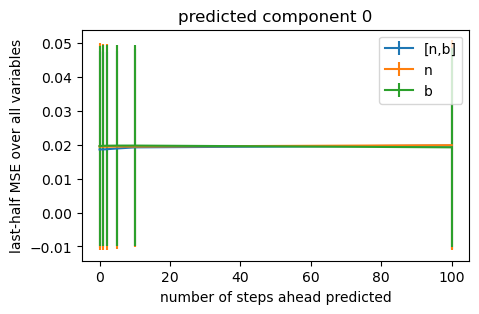

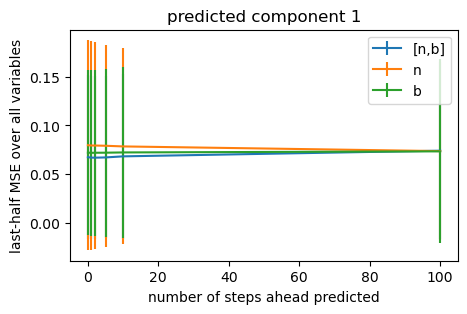

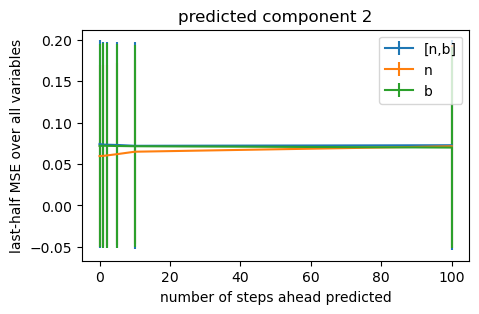

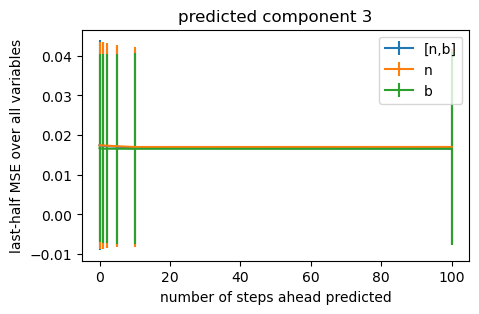

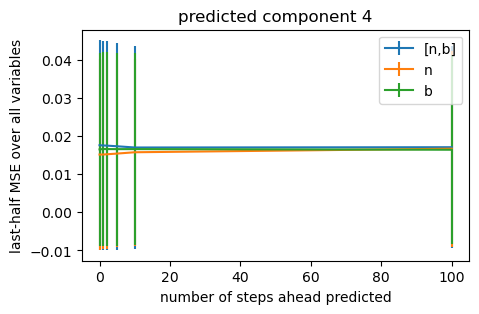

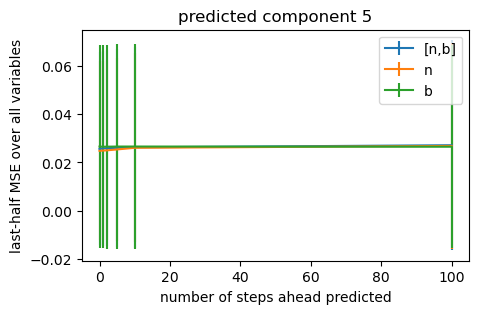

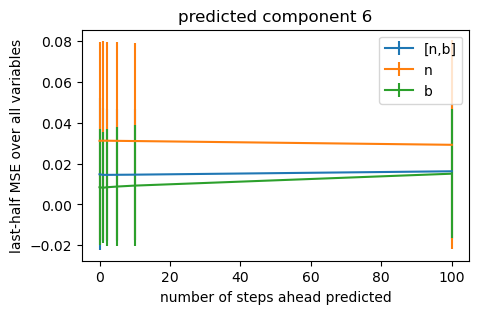

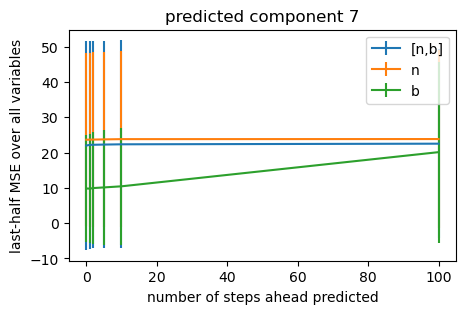

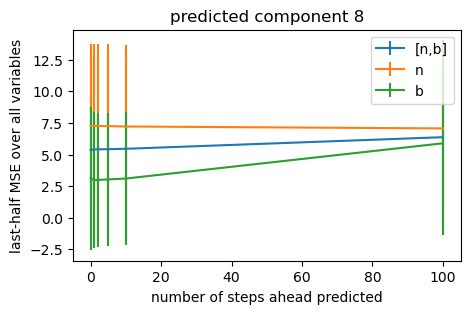

In [717]:
%matplotlib inline
for i in range(9):
    plt.figure(figsize=(5,3))
    for group in ["[n,b]","n","b"]:
        sdf = df[df.data_in == group]
        mse_s = []
        stds = []
        for br in sdf.br:
            es = br.beh_error_list[len(br.beh_error_list)//2:,i]
            mse_s.append(es.mean())
            stds.append(es.std())
        plt.errorbar((sdf.n_steps_ahead), mse_s, yerr=stds, label=group) 
        plt.ylabel("last-half MSE over all variables")
        plt.xlabel("number of steps ahead predicted")
        plt.title(f"predicted component {i}")
    plt.legend()

In [699]:
mse_s

[array([0.02548421, 0.0285368 , 0.03251271, ..., 0.2643167 , 0.26405993,
        0.26380357], dtype=float32),
 array([0.03039487, 0.03424201, 0.03848235, ..., 0.24338087, 0.24368057,
        0.24398702], dtype=float32),
 array([0.03064899, 0.0345785 , 0.03856467, ..., 0.23390388, 0.23400797,
        0.23411775], dtype=float32),
 array([0.03940918, 0.04326866, 0.04684066, ..., 0.23145425, 0.23144823,
        0.23144235], dtype=float32),
 array([0.04812697, 0.05150895, 0.05393343, ..., 0.23034368, 0.23033674,
        0.23032978], dtype=float32),
 array([0.01230144, 0.01424138, 0.01611274, ..., 0.18147036, 0.20792153,
        0.22882906], dtype=float32)]

In [684]:
steps = df.loc[0,'br'].entropy_list.shape[0]
ttr = df.loc[0,'br'].time_to_run
print(f"total time to run: {ttr}")
print(f"{1000*ttr/steps} ms/it or {steps/ttr}it/s")

total time to run: 126.68964672088623
1.772205390083319 ms/it or 564.2686821717575it/s


In [685]:
w_time = df.loc[0,'br'].time_spent_on_w

print(f"total time spent on w: {w_time}")
print(f"{1000*w_time/steps} ms/it")

total time spent on w: 34.84899401664734
0.487487151742937 ms/it


In [676]:
rows = [4,5,6]

dfile = np.load("../../" + df.loc[rows[0],"br"].file)



n = df.loc[rows[0],"br"].beh_list.shape[0]
to_predict = np.hstack([dfile["y"][0], dfile["x"]])[:n]

variable_labels = [f"neural data {x}" for x in range(4)] + ["run speed", "pupil size"] + [f"video svd[:,{x}]" for x in range(10)] 

l = []
names = []
for row in rows:
    l.append(((df.loc[row,"br"].beh_list - to_predict)**2).mean(axis=0))
    names.append(df.loc[row,"data_in"])

In [677]:
result = pd.DataFrame(np.array(l), index=names)
result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
"z(b,n)",694176.739634,1.176661e+06,969886.964804,1.242224e+06,68.849939,88099.961963,8.459634e+05,102903.127247,38825.956420,40330.820855,26453.227829,21529.530419,26224.359711,16510.329396,15676.977280,13679.883628
z(n),455146.921873,3.686529e+05,434445.360419,4.225180e+05,32.596767,42281.841091,1.180513e+06,79822.911825,39120.328148,36771.832049,25461.287165,20524.578837,21700.151682,15436.072303,15205.435111,13026.482343
z(b),679830.365200,1.166880e+06,983816.778098,1.094201e+06,53.377296,74222.330925,4.816742e+05,89566.372060,35693.777402,36025.963136,22743.197991,19511.412137,24919.194872,15061.373718,13130.832761,12570.060252


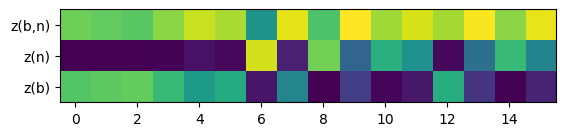

In [678]:
%matplotlib inline
normalized_result = (result - result.mean(axis=0))/result.std(axis=0)
plt.imshow(normalized_result)
plt.yticks(ticks=[0,1,2],labels=normalized_result.index,rotation=0);

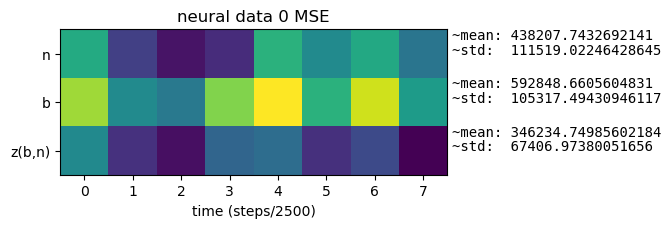

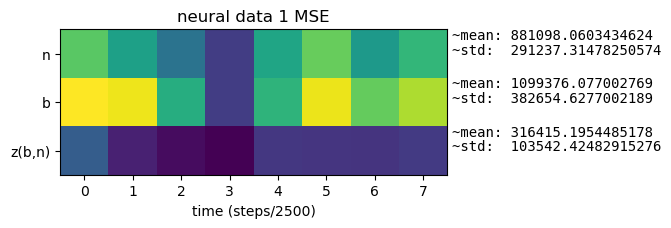

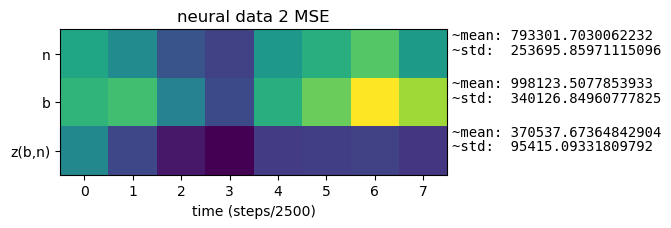

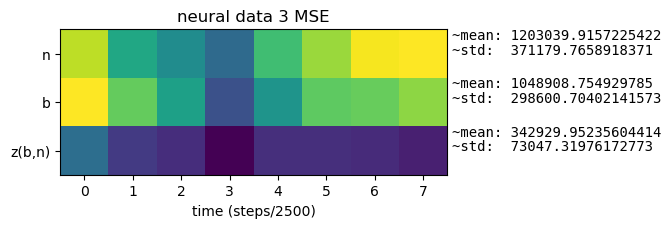

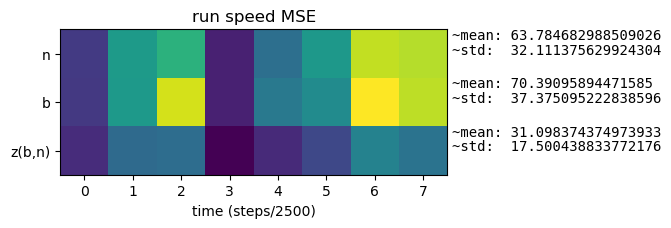

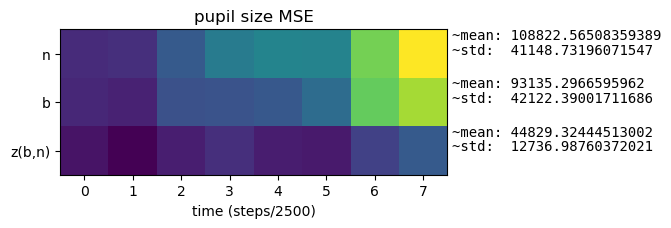

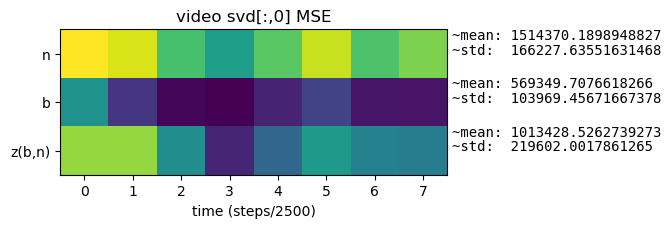

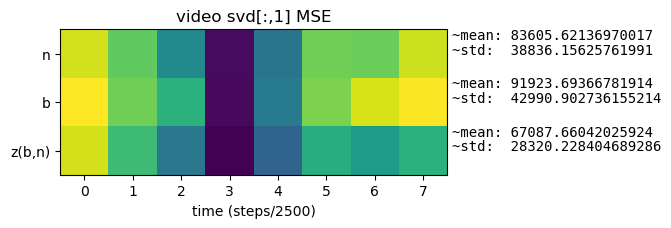

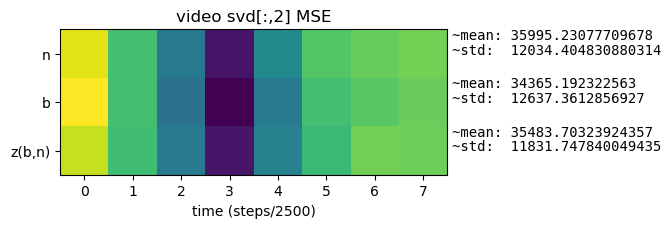

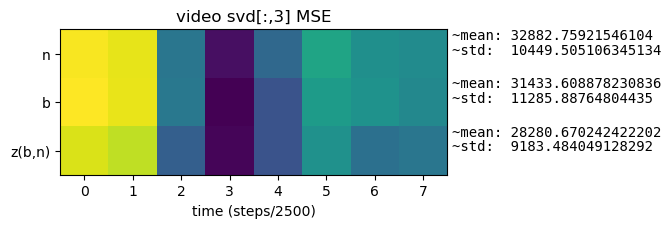

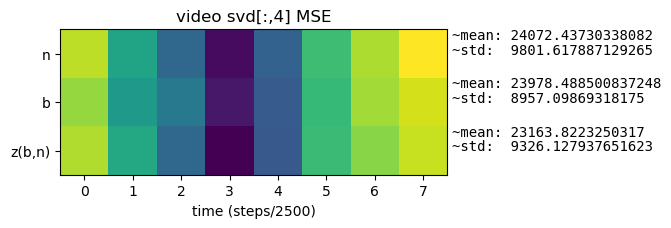

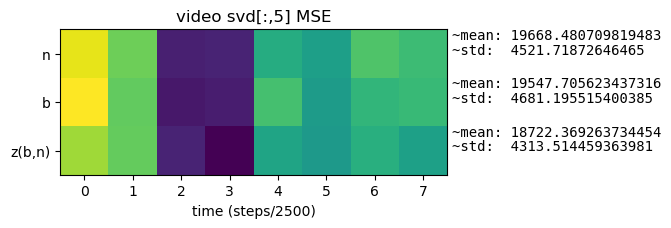

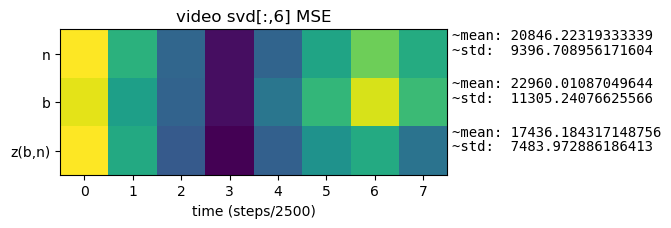

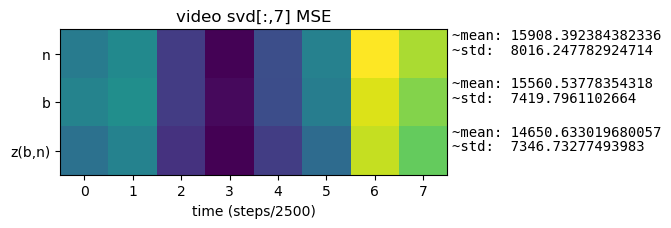

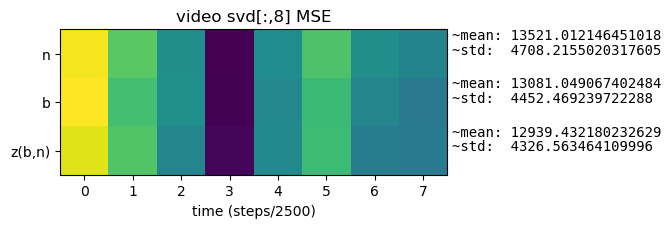

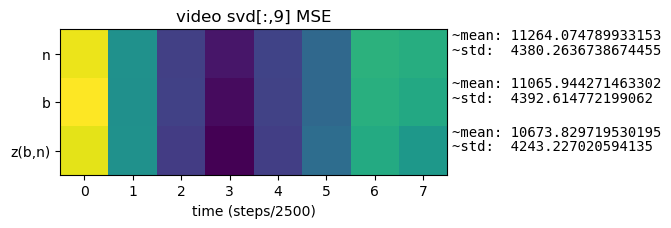

In [670]:
%matplotlib inline
jump_size = 2_500
edges = np.arange(0,n,jump_size)

all_errors = []
for i in range(len(edges)-1):
    s = slice(edges[i],edges[i+1])
    l = []
    for row in rows:
        l.append(((df.loc[row,"br"].beh_list[s,:] - to_predict[s,:])**2).mean(axis=0))
    all_errors.append(l)
all_errors = np.array(all_errors)
# v_number = 0
for v_number in range(16):
    plt.figure(figsize=(5,10))
    this_variable = all_errors[:,:,v_number].T
    plt.imshow(this_variable)
    plt.xlabel(f"time (steps/{jump_size})")
    plt.yticks(ticks=[0,1,2],labels=normalized_result.index,rotation=0);
    plt.title(f"{variable_labels[v_number]} MSE")
    for i in range(this_variable.shape[0]):
        plt.text(7.6,i-.3, f"~mean: {this_variable[i,2:].mean()}", fontfamily="monospace")
        plt.text(7.6,i   , f"~std:  {this_variable[i,2:].std(ddof=1)}", fontfamily="monospace")

In [669]:
%matplotlib qt
i = 1

plt.plot(to_predict[:,i], 'k')
for row in rows:
    plt.plot(df.loc[row, "br"].beh_list[:,i], label=df.loc[row, "data_in"])
plt.legend()


Text(0.5, 0, 'time (steps/5000)')

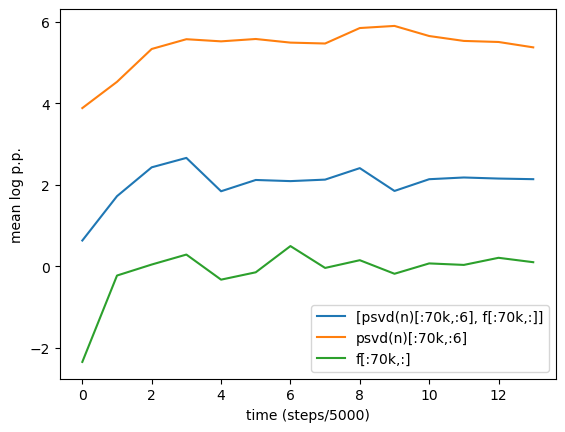

In [337]:
plt.plot(all_pred)
plt.legend(normalized_result.index)
plt.ylabel("mean log p.p.")
plt.xlabel(f"time (steps/{jump_size})")

In [335]:
jump_size = 5_000
edges = np.arange(0,70_001,jump_size)

all_pred = []
for i in range(len(edges)-1):
    s = slice(edges[i],edges[i+1])
    l = []
    for row in rows:
        l.append(df.loc[row,"br"].pred_list[s,0].mean())
    all_pred.append(l)
all_pred = np.array(all_pred)
# v_number = 0
for v_number in range(9):
    plt.figure()
    plt.imshow(all_pred[:,:,v_number].T)
    # plt.xlabel(f"time (steps/{jump_size})")
    # plt.yticks(ticks=[0,1,2],labels=normalized_result.index,rotation=0);
    # plt.title(f"predicted variable {v_number} MSE")

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

<Figure size 640x480 with 0 Axes>

In [523]:
to_predict = np.linalg.norm(f - f[0], axis=1)[:,None]
to_predict = f[:,2]
to_predict = psvd_n[:,0]




i = 0
to_predict = f[:,i]
plt.plot(to_predict)

to_compare = [0]
# to_compare = [30]
for i in to_compare:
    x = np.arange(df.loc[i,"br"].beh_list.shape[0])+df.loc[i,"n_steps_ahead"]
    beh_pred = df.loc[i,"br"].beh_list[:,i]
    plt.plot(x,beh_pred)
    
half_width = 3000

kernel = np.ones(half_width * 2)
kernel = kernel/kernel.sum()
mov_avg = np.convolve(np.squeeze(to_predict), kernel, mode='valid')
x = np.arange(mov_avg.shape[0])
# plt.plot(x + half_width*2, mov_avg)

In [172]:
n

70587

In [171]:
n = beh_pred.shape[0]
perm = rng.permutation(np.arange(n))

cut_to_predict = to_predict[:n]
constant_mse = ((cut_to_predict - cut_to_predict.mean())**2).mean()
constant_mse = 1

print(((beh_pred - cut_to_predict)**2).mean()/constant_mse)
print(((beh_pred[perm] - cut_to_predict)**2).mean()/constant_mse)

35.20325409542451
35.214464955484196


In [152]:
to_predict.shape

(71487,)

In [117]:
plt.imshow(np.corrcoef(np.hstack([df.loc[i,"br"].beh_list]).T))

In [599]:
ws = [1, 100, 500, 1000, 1500, 2000, 2500, 3000, 4000, 50000]
ds = []
for w in ws:
    half_width = w
    kernel = np.ones(half_width * 2)
    kernel = kernel/kernel.sum()
    mov_avg = np.convolve(np.squeeze(to_predict), kernel, mode='valid')

    aligned_beh = beh_pred[half_width*2-df.loc[i,"n_steps_ahead"]:]

    ds.append(((mov_avg[aligned_beh.shape[0]] -  aligned_beh)**2).mean())

/tmp/ipykernel_321888/3372268095.py:11: RuntimeWarning: Mean of empty slice.
  ds.append(((mov_avg[aligned_beh.shape[0]] -  aligned_beh)**2).mean())
/home/jgould/miniconda3/envs/bubblewrap/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [600]:
plt.plot(ws,ds)

In [606]:
f.shape

(71487, 3)

In [272]:
plt.plot(df.loc[5,"br"].beh_error_list)

In [559]:
runs = [10,11,12,13,25,26,27,28]
plt.plot(df.loc[runs,"n_steps_ahead"], df.loc[runs,"mse"], '.-', label=df.loc[runs[0], "data_in"])

runs = range(14,24)
plt.plot(df.loc[runs,"n_steps_ahead"], df.loc[runs,"mse"], '.-', label=df.loc[runs[0], "data_in"])
plt.ylabel("mse")
plt.xlabel("number of steps ahead")
plt.legend()

In [445]:
df.loc[18,"br"].beh_list.shape

(20100, 3)

In [283]:
br.beh_list

array([ 0.        , -0.29783689, -0.39488284, ..., -0.45637971,
       -0.45635001, -0.45631898])

# Old

## Smoothed Entropy/Prop plot

In [98]:
def one_sided_ewma(data, com=100):
    return pd.DataFrame(data=dict(data=data)).ewm(com).mean()["data"]

def two_sided_ewma(data, half_width=75):
    kernel = np.linspace(0,10,half_width)
    kernel = np.exp(kernel)
    kernel = np.hstack((kernel, np.flip(kernel)))
    kernel = kernel/kernel.sum()
    return np.convolve(data, kernel, 'valid')

In [9]:
# calculates for the next cell

T = new_way_br.pred_list.shape[0]
new_way_means = []
old_way_means = []
shuffled_means = []

new_way_stds = []
old_way_stds = []
shuffled_stds = []
for i, step in enumerate(new_way_br.bw_parameters["lookahead_steps"]):
    first_nonzero = np.nonzero(np.isnan(new_way_br.pred_list[:,i]))[0]
    if len(first_nonzero):
        local_T = first_nonzero[0]
    else:
        local_T = T
    new_way_means.append(np.mean(new_way_br.pred_list[-local_T//2:local_T,i]))
    new_way_stds.append(np.std(new_way_br.pred_list[-local_T//2:local_T,i], ddof=1))
    # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")

for i, step in enumerate(old_way_br.bw_parameters["lookahead_steps"]):
    old_way_means.append(np.mean(old_way_br.pred_list[-T//2:,i]))
    old_way_stds.append(np.std(old_way_br.pred_list[-T//2:,i], ddof=1))
    # print(f"old way {step:>2} step(s) ahead mean: {old_way_means[-1]}")

if shuffled_br is not None:
    for i, step in enumerate(shuffled_br.bw_parameters["lookahead_steps"]):
        first_nonzero = np.nonzero(np.isnan(shuffled_br.pred_list[:,i]))[0]
        if len(first_nonzero):
            local_T = first_nonzero[0]
        else:
            local_T = T
        shuffled_means.append(np.mean(shuffled_br.pred_list[-local_T//2:local_T,i]))
        shuffled_stds.append(np.std(shuffled_br.pred_list[-local_T//2:local_T,i], ddof=1))
        # print(f"new way {step:>2} step(s) ahead mean: {new_way_means[-1]}")


new_way_means = np.array(new_way_means)
old_way_means = np.array(old_way_means)

new_way_stds = np.array(new_way_stds)
old_way_stds = np.array(old_way_stds)

if shuffled_br is not None:
    shuffled_stds = np.array(shuffled_stds)
    shuffled_means = np.array(shuffled_means)

NameError: name 'new_way_br' is not defined

### Over Time

#### Tune smoothing factor

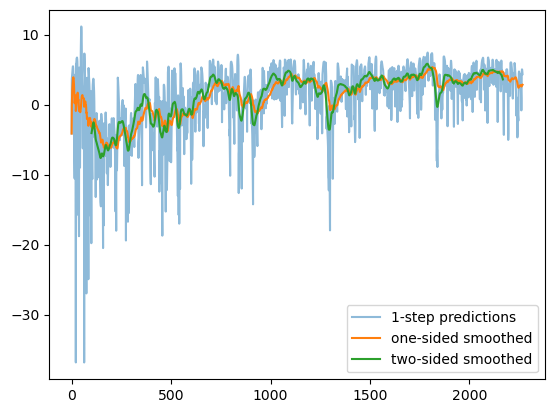

In [34]:
if not all_inline:
    %matplotlib qt


data = old_way_br.pred_list[:,0]
smoothed_data1 = one_sided_ewma(data,40)

plt.plot(data, alpha=.5)
plt.plot(smoothed_data1);

half_width = 100
smoothed_data2 = two_sided_ewma(data,half_width)
plt.plot(np.arange(smoothed_data2.size) + half_width, smoothed_data2);

plt.legend(["1-step predictions", "one-sided smoothed", "two-sided smoothed"]);

#### Smoothed Predictions and alpha

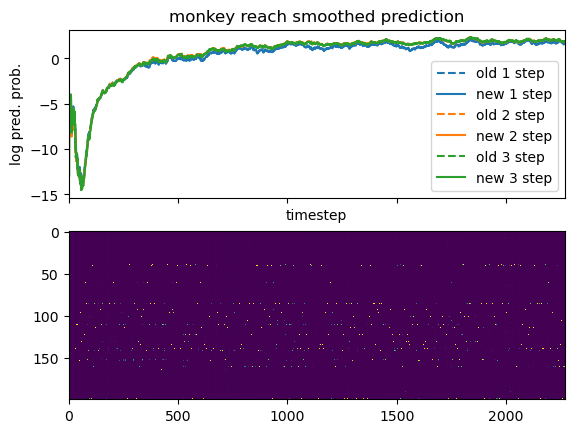

In [35]:
# shows smoothed predictions over time

if not all_inline:
    %matplotlib qt
    
show_states_instead_of_alpha = True

smoothing_scale = 40
br = shuffled_br

fig, axs = plt.subplots(2,1, sharex=True)
steps = [1,2,3]
for si, step in enumerate(steps):
    i = br.bw_parameters["lookahead_steps"].index(step)
    old_pred = br.pred_list[:,i]
    new_pred = br.pred_list[:,i]
    # plt.plot(pred)


    smoothed_old_pred = one_sided_ewma(old_pred, smoothing_scale)
    smoothed_new_pred = one_sided_ewma(new_pred, smoothing_scale)
    half_width = 0 # NOTE: set this if you use the two-sided ewma function
    
    axs[0].plot(np.arange(smoothed_old_pred.size) + half_width, smoothed_old_pred, color=f'C{si}', linestyle='dashed')
    x_correction = (step-1)*1
    axs[0].plot(np.arange(smoothed_new_pred.size) + half_width + x_correction,smoothed_new_pred, color=f'C{si}',linestyle='solid')

legend = []
for step in steps:
    legend.append(f"old {step} step")
    legend.append(f"new {step} step")
axs[0].legend(legend)
axs[0].set_title(f"{dataset} smoothed prediction")
axs[0].set_xlabel("timestep")
axs[0].set_ylabel("log pred. prob.");



if states is not None and show_states_instead_of_alpha:
    axs[1].plot(states,'.')
else:
    alpha = br.alpha_list.T
    state_means = alpha.mean(axis=1)
    # alpha = alpha[state_means > np.quantile(state_means, .75),:]
    alpha = alpha[np.argsort(-alpha.mean(axis=1)) - (alpha.shape[0]//2),:]
    axs[1].imshow((alpha), aspect="auto", interpolation="nearest")
# axs[0].set_xlim([500, 1000])

#### Smoothed predictions and entropy

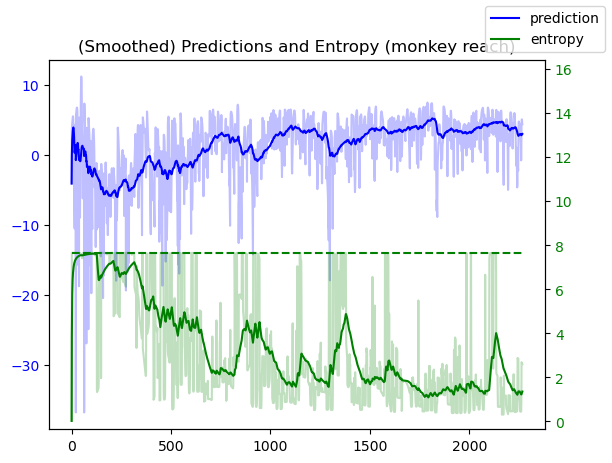

In [36]:
# shows smoothed predictions and entropy
if not all_inline:
    %matplotlib qt

    
br = new_way_br

smooting_scale = 50

predictions = br.pred_list[:,0]
smoothed_predictions = one_sided_ewma(predictions,smooting_scale)

fig, ax1 = plt.subplots()
ax1.plot(predictions, alpha=0.25, color='blue')
ax1.plot(smoothed_predictions, color='blue', label = "prediction")
ax1.tick_params(axis='y',labelcolor='blue')
ax1.set_title(f"(Smoothed) Predictions and Entropy ({dataset})")


entropy = br.entropy_list[:,0]
smoothed_entropy = one_sided_ewma(entropy, smooting_scale)
ax2 = ax1.twinx()
ax2.plot(entropy, color='green', alpha=0.25)
ax2.plot(smoothed_entropy, color='green', label="entropy")
max_entropy = np.log2(br.bw_parameters["num"])
ax2.plot([0, entropy.shape[0]], [max_entropy,]*2, 'g--')
ax2.tick_params(axis='y',labelcolor='green')
ymin, ymax = ax2.get_ylim()
ax2.set_ylim((ymin, 2*(ymax-ymin) + ymin))

fig.legend()

# Alpha analysis

In [641]:
plt.plot(br.alpha_list[:,br.dead_nodes].sum(axis=1))

# Exponentially weighted least squares

### Artificial Regression Problem

In [832]:
rng = np.random.default_rng()

In [833]:
d = 2
n = 100

w_true = np.array([-1,1]).reshape(-1,1)

C = np.zeros(shape=(0,d))
for i in range(n):
    alpha = rng.multivariate_normal([1,1],[[1,0],[0,1]]).reshape(-1,1)
    C = np.vstack((C,alpha.T))
    
y= rng.multivariate_normal(np.squeeze(C @ w_true), np.diag([.9**x for x in range(n)]))

### Real regression Problem

In [844]:
C = br.alpha_list

y = np.tile(obs,C.shape[0]//obs.shape[0])[:,None]
y.shape

(6804, 1)

### Vanilla

In [845]:
w = 30
D = np.linalg.inv(C[:w,:].T @ C[:w,:])
Ct_y = C[:w,:].T @ y[:w]

for i in range(w,n):
    alpha = C[i,:,None]
    D = D - D @ alpha @ alpha.T  @ D/(1 + alpha.T @ D @ alpha)
    Ct_y = Ct_y + y[i] * alpha
    

In [724]:
%matplotlib qt
fig, axs = plt.subplots(nrows=2,ncols=1)
axs[0].plot(D@Ct_y, label="vanilla")
axs[0].plot(wD@wCt_y, label="weighted")

axs[1].plot(np.linalg.inv(C.T @ C)@C.T@y, label="vanilla")
axs[1].plot(np.linalg.inv(C.T @ C + np.eye(C.shape[1]))@C.T@y, label="normalized")

axs[1].plot(np.linalg.inv(C.T @ (pre_V[:,None] * C)) @ (C.T * pre_V)  @ y, label="weighted")
axs[1].plot(np.linalg.inv(C.T @ (pre_V[:,None] * C) + np.eye(C.shape[1])) @ (C.T * pre_V)  @ y, label="weighted normalized")


axs[0].set_title("iterative")
axs[1].set_title("batch")

axs[0].legend()
axs[1].legend()

### Vanilla with observation number-based reweighting

In [846]:
ww = br.beh_counts.sum(axis=1)

In [847]:
print(f"{np.allclose(np.linalg.inv(C.T @ C), D) = }")
print(f"{np.allclose(C.T @ y, Ct_y) = }")

np.allclose(np.linalg.inv(C.T @ C), D) = False
np.allclose(C.T @ y, Ct_y) = False


### Weighted version

In [727]:
v = .997

pre_V = np.array([v**(n-(i+1)) for i in range(C.shape[0])])


In [740]:
w = 30

sub_V = np.diag([v**(w-(i+1)) for i in range(w)])
wD = np.linalg.inv(C[:w,:].T @ sub_V @ C[:w,:])
wCt_y = C[:w,:].T@ sub_V @ y[:w]

for i in range(w,n):
    alpha = C[i,:,None]
    wD = wD/v
    wD = wD - wD @ alpha @ alpha.T  @ wD/(1 + alpha.T @ wD @ alpha)
    wCt_y = v*wCt_y + y[i] * alpha
    

In [752]:
print(f"{np.allclose(np.linalg.inv(C.T * pre_V @ C), wD) = }")
print(f"{np.allclose(C.T @ (pre_V[:,None] * y), wCt_y) = }")

np.allclose(np.linalg.inv(C.T * pre_V @ C), wD) = False
np.allclose(C.T @ (pre_V[:,None] * y), wCt_y) = False


In [759]:
((np.linalg.inv(C.T @ C) @ C.T @ y - w_true.T)**2).sum() - ((np.linalg.inv(C.T @ (pre_V[:,None] * C)) @ C.T @ (pre_V[:,None] * y) - w_true.T)**2).sum()

-67579330356791.45